# Popularity comparison vs Youtube's

## Loading data

In [ ]:
import pyspark

spark = (pyspark.sql.SparkSession.builder \
         .master('local') \
         .appName('Introduction to PySpark') \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate())

sc = spark.sparkContext

In [ ]:
SCHEME = 's3a'
# TODO: Set your BUCKET_NAME and PREFIX
BUCKET_NAME = ''
PREFIX = ''
### BEGIN STRIP ###

### END STRIP ###

def get_s3_path(key, bucket_name=BUCKET_NAME, scheme=SCHEME):
  return f"{scheme}://{bucket_name}/{key}"

ACCESS_KEY_ID = "ACCESS_KEY_ID" # cle du compte student
SECRET_ACCESS_KEY = "SECRET_ACCESS_KEY" # secret key du compte student

hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.access.key", ACCESS_KEY_ID)
hadoop_conf.set("fs.s3a.secret.key", SECRET_ACCESS_KEY)
hadoop_conf.set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem") 

In [ ]:
# TODO: Load the parquet file into a PySpark DataFrame: `playlog`
# TODO: Perform the usual checks
### BEGIN STRIP ###
playlog = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("s3://full-stack-bigdata-datasets/Big_Data/youtube_playlog.csv")
playlog.printSchema()
### END STRIP ###

root
-- timestamp: integer (nullable = true)
-- user: integer (nullable = true)
-- song: string (nullable = true)

In [ ]:
# TODO: Load the parquet file into a PySpark DataFrame: `songs`
# TODO: Perform the usual checks
songs_filename = 'items_selected.parquet'
### BEGIN STRIP ###
songs = spark.read.load(f"s3://full-stack-bigdata-datasets/Big_Data/YOUTUBE/{songs_filename}")
songs.printSchema()
songs.count(), len(songs.columns)
### END STRIP ###

root
-- contentDetails_duration: string (nullable = true)
-- id: string (nullable = true)
-- snippet_channelId: string (nullable = true)
-- snippet_channelTitle: string (nullable = true)
-- snippet_publishedAt: string (nullable = true)
-- snippet_title: string (nullable = true)
-- statistics_commentCount: long (nullable = true)
-- statistics_dislikeCount: long (nullable = true)
-- statistics_viewCount: long (nullable = true)

Out[7]: (3907, 9)

## Computing a variable: `statistics_playCount`
We already have a few statistics from the data we collected from Youtube, e.g. `statistics_viewCount`, `statistics_commentCount` and `statistics_dislikeCount`.  
We will compute a new statistics `statistics_playCount`, this one based on our user history: the number of times this song has been played on our service.

We will save this as a new DataFrame `playcounts` that we will later merge with others.

In [ ]:
# TODO: Compute `playcounts`
#       The playcount for each song in the playlog
#       Alias the new column to `statistics_playCount`
### BEGIN STRIP ###
statistics_playCount = playlog.groupBy("song").count().orderBy("count", ascending=False).withColumnRenamed("count","statistics_playCount")
statistics_playCount.show(5)
### END STRIP ###


+-----------+--------------------+
 song|statistics_playCount|
+-----------+--------------------+
SYM-RJwSGQ8| 25874|
UfR3nAz8z3Q| 19537|
MYSVMgRr6pw| 18178|
6ktYpaGVUe0| 16032|
bpOSxM0rNPM| 14521|
+-----------+--------------------+
only showing top 5 rows

Now we will join this with our `songs` DataFrame. Call the resulting DataFrame `songs_with_playcount`.

In [ ]:
# TODO: join `songs` with `playcounts`: `songs_with_playcount`
#       Then: - print out the schema of the new DataFrame
#             - print out the first 5 rows
### BEGIN STRIP ###
songs_with_playcount = songs.join(statistics_playCount, songs.id == statistics_playCount.song)
songs_with_playcount.limit(5).toPandas()
### END STRIP ###

Out[84]:

,contentDetails_duration,id,snippet_channelId,snippet_channelTitle,snippet_publishedAt,snippet_title,statistics_commentCount,statistics_dislikeCount,statistics_viewCount,song,statistics_playCount
0,PT3M59S,3vFKqs32lyA,UCPUVB4vRHi8Yg20IFI89PKQ,sunaker,2012-12-22T07:39:22Z,Kaveret - Yo Ya,27,7,39035,3vFKqs32lyA,17
1,PT3M48S,jFS8mVhP0xg,UCN4BoFTD9YncU-NpJr8YyBw,HHVIBE,2013-10-09T16:31:44Z,Restless Leg Syndrome - Sharitt Casette,14,7,53405,jFS8mVhP0xg,124
2,PT3M12S,hicCHaC_z5I,UCCbpTuRINyfjtwFkjHuII1w,mau5trap,2012-10-11T18:37:14Z,Feed Me & Crystal Fighters - Love Is All I Got...,2422,1072,7768503,hicCHaC_z5I,462
3,PT2M56S,yc7TpfKOgwA,UCmIpgKCKzgzOy_Ju_GDClNw,Walrus81,2012-03-20T13:02:08Z,The Smashing Pumpkins - Stumbleine,1,0,1454,yc7TpfKOgwA,2
4,PT4M27S,_iujjGCoF4g,UCnUbD-Jek5_8IfDbMJ3rn7Q,92JuggaLotus503,2009-01-02T23:22:40Z,Aesop Rock- Daylight,193,82,484936,_iujjGCoF4g,86


## Performing analysis
We will plot a few graph.

Out[86]:

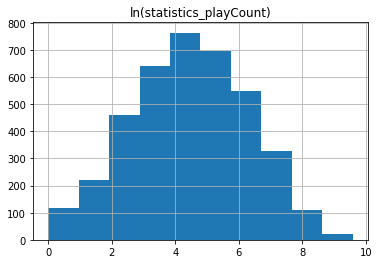

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4189e57410>]],
 dtype=object)

In [ ]:
from pyspark.sql import functions as F

df = songs_with_playcount.select(F.log("statistics_playCount")).toPandas()
df.hist()

Out[87]:

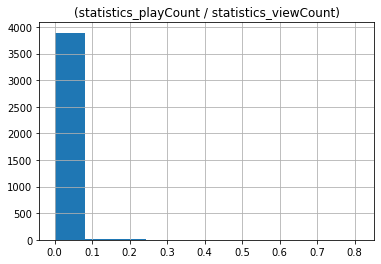

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4189e61dd0>]],
 dtype=object)

In [ ]:
df = songs_with_playcount.select(F.col("statistics_playCount") / F.col("statistics_viewCount")).toPandas()
df.hist()

Another power law. We will take the log of this and plot it.

Out[88]:

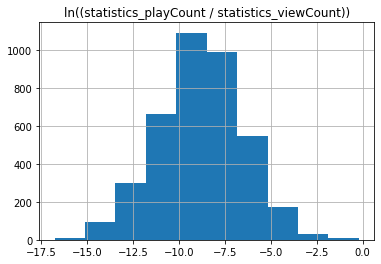

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4189d6d8d0>]],
 dtype=object)

In [ ]:
df = songs_with_playcount.select(F.log(F.col("statistics_playCount") / F.col("statistics_viewCount"))).toPandas()
df.hist()

Out[93]:

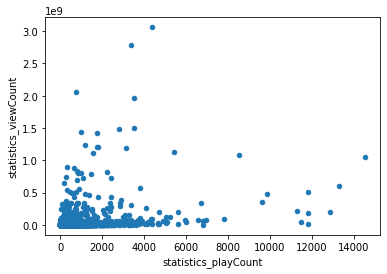

<matplotlib.axes._subplots.AxesSubplot at 0x7f418ad126d0>

In [ ]:
# TODO: Plot an a scatter plot of `statistics_playCount` vs `statistics_playcount`
#       Tick "Show LOESS" 
### BEGIN STRIP ###
df = songs_with_playcount.select("statistics_playCount", "statistics_viewCount").toPandas()
df.plot.scatter("statistics_playCount", "statistics_viewCount")
### END STRIP ###

Out[95]:

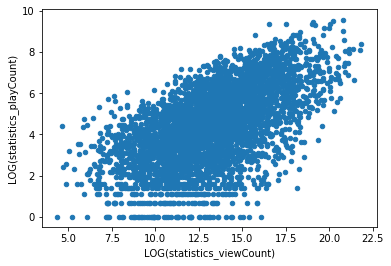

<matplotlib.axes._subplots.AxesSubplot at 0x7f418b235890>

In [ ]:
# TODO: Plot an a scatter plot of log `statistics_playCount` vs log `statistics_playcount`
#       Tick "Show LOESS" 
### BEGIN STRIP ###
df = songs_with_playcount.select(F.log('statistics_viewCount').alias('LOG(statistics_viewCount)'),
                                 F.log('statistics_playCount').alias('LOG(statistics_playCount)')).toPandas()
df.plot.scatter('LOG(statistics_viewCount)', 'LOG(statistics_playCount)')
### END STRIP ###

Out[102]:

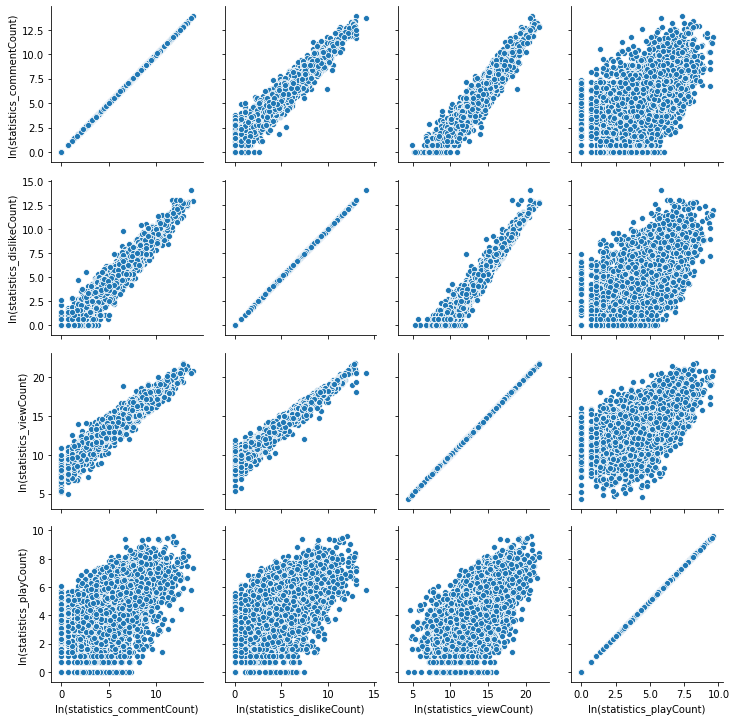

<seaborn.axisgrid.PairGrid at 0x7f418a8f45d0>

In [ ]:
# TODO: plot multiple scatter plots (grid plot?) of all `statistics_` columns
### BEGIN STRIP ###
import seaborn as sns

df = songs_with_playcount.select([F.log(col) for col in songs_with_playcount.columns if "statistics_" in col]).toPandas()
g = sns.PairGrid(df)
g.map(sns.scatterplot)
### END STRIP ###

**[TODO]** What can you say?